In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np 
import sys

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

In [88]:
history = 10
error = 1e-8

ω_size = 500
ω_range  = np.linspace(w2f(1.546e-6)/ω0, w2f(1.554e-6)/ω0, ω_size) # [Hz/ω0]
E_size = 4
E_range = np.power(np.logspace(-3., -2., num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.append(np.logspace(-1, 1, num=E_size/2, endpoint=True),np.logspace(1.02, 1.05, num=E_size/2, endpoint=True)) , 0.5)

In [103]:
verbose = False
loops = True
maxit = 4e4

### generate empty data storage
d = {}
d['xUp']  = np.zeros((ω_size,E_size,history), dtype=complex)
d['xUs']  = np.zeros((ω_size,E_size,history), dtype=complex)
d['xUtot']= np.zeros((ω_size,E_size,history), dtype=float)
d['xΔN']  = np.zeros((ω_size,E_size,history), dtype=float)
d['xΔT']  = np.zeros((ω_size,E_size,history), dtype=float)
d['xΔω']  = np.zeros((ω_size,E_size,history), dtype=complex)

### two nested for loops, in input power and in
for E_idx in range(E_size):
    for ω_idx in range(ω_size):
        ### reset iteration index
        it = 0
        
        #params = (ωs, ωp, ω0, Ep, Es, τa, τb, τ0, 𝛾TH, 𝛾FC, MCp, n0, n2, dndT, dndN, dαdN, βtpa, Γ, V, Veff)
        #ñparams = (ω_range[ω_idx], ωp, ω0, E_range[E_idx], Es, τa, τb, τ0, 𝛾TH, 𝛾FC, MCp, n0, n2, dndT, dndN, dαdN, βtpa, Γ, V, Veff)
        ñparams = (ω_range[ω_idx], w2f(1549.9e-9)/ω0, ñω0, np.sqrt(5.0), E_range[E_idx], 0.25*ñτa, 0.25*ñτb, 0.25*ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        
        ### generate first set of data, with all initial condition set to zero ("cold resonance")
        if ω_idx == 0:
            new_var = ñequations((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), ñparams)
        else:
            x0 = (d['xUp'][ω_idx-1,E_idx,0], d['xUs'][ω_idx-1,E_idx,0], d['xUtot'][ω_idx-1,E_idx,0], d['xΔN'][ω_idx-1,E_idx,0], d['xΔT'][ω_idx-1,E_idx,0], d['xΔω'][ω_idx-1,E_idx,0])
            new_var = ñequations(x0, ñparams)
            del x0
        
        d['xUp'][ω_idx,E_idx,0]   = new_var[0]
        d['xUs'][ω_idx,E_idx,0]   = new_var[1]
        d['xUtot'][ω_idx,E_idx,0] = new_var[2]
        d['xΔN'][ω_idx,E_idx,0]   = new_var[3]
        d['xΔT'][ω_idx,E_idx,0]   = new_var[4]
        d['xΔω'][ω_idx,E_idx,0]   = new_var[5]
        del new_var
        
        while (np.abs(d['xUtot'][ω_idx,E_idx,0]-d['xUtot'][ω_idx,E_idx,1]) >= error) & (it<=maxit):
            it += 1
            
            ### shift the history data
            d['xUp'][ω_idx,E_idx,1:history]   = d['xUp'][ω_idx,E_idx,0:history-1]
            d['xUs'][ω_idx,E_idx,1:history]   = d['xUs'][ω_idx,E_idx,0:history-1]
            d['xUtot'][ω_idx,E_idx,1:history] = d['xUtot'][ω_idx,E_idx,0:history-1]
            d['xΔN'][ω_idx,E_idx,1:history]   = d['xΔN'][ω_idx,E_idx,0:history-1]
            d['xΔT'][ω_idx,E_idx,1:history]   = d['xΔT'][ω_idx,E_idx,0:history-1]
            d['xΔω'][ω_idx,E_idx,1:history]   = d['xΔω'][ω_idx,E_idx,0:history-1]
            
            ### put old data in vector, to become input of equations()
            old_var = (d['xUp'][ω_idx,E_idx,1], d['xUs'][ω_idx,E_idx,1], d['xUtot'][ω_idx,E_idx,1], d['xΔN'][ω_idx,E_idx,1], d['xΔT'][ω_idx,E_idx,1], d['xΔω'][ω_idx,E_idx,1])
            
            ### generate new values
            new_var = ñequations(old_var, ñparams)
            
            ### store new values
            d['xUp'][ω_idx,E_idx,0]   = new_var[0]
            d['xUs'][ω_idx,E_idx,0]   = new_var[1]
            d['xUtot'][ω_idx,E_idx,0] = new_var[2]
            d['xΔN'][ω_idx,E_idx,0]   = new_var[3]
            d['xΔT'][ω_idx,E_idx,0]   = new_var[4]
            d['xΔω'][ω_idx,E_idx,0]   = new_var[5]
        
        if verbose:
            print("%3.1f"%((1.0+ω_idx)/ω_size*100), "%%\tP %.2e,"%(E_range[E_idx]**2*P0), " λ %.5f"%f2w(ω_range[ω_idx]*1e-6*ω0), end='')
            print(", iteration # %d,"%it , " error %.4e"%np.abs(d['xUtot'][ω_idx,E_idx,0]-d['xUtot'][ω_idx,E_idx,1]))
    if loops:
        print("%3.1f"%((1.0+E_idx)/E_size*100), "%%\tP %.2f"%(E_range[E_idx]**2),"mW loop completed.")
    elif not verbose:
        print()

print("\nall loops have been completed.")

25.0 %	P 0.00 mW loop completed.
50.0 %	P 0.00 mW loop completed.
75.0 %	P 0.00 mW loop completed.
100.0 %	P 0.01 mW loop completed.

all loops have been completed.


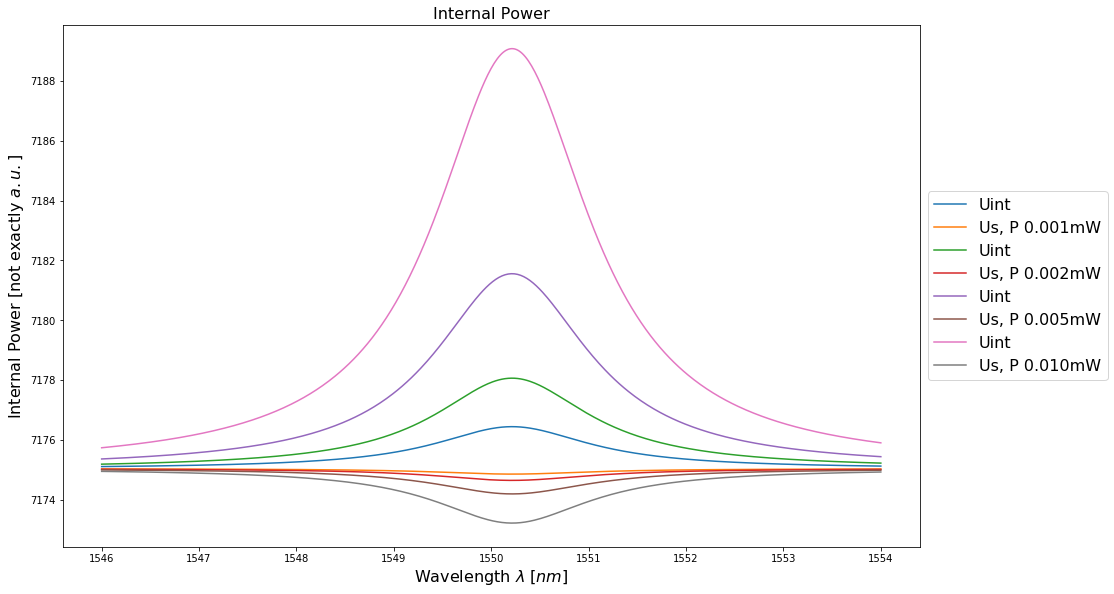

In [104]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])

for E_idx in range(E_size):
    #if E_idx < E_size-4:
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['xUtot'][:,E_idx,0], label='Uint')
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['xUp'][:,E_idx,0])**2, label='Us, P %.3fmW'%E_range[E_idx]**2)
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['xUtot'][:,E_idx,0]-np.mean(d['xUtot'][:,E_idx,0]), label='Uint, P %.3f'%E_range[E_idx]**2 ) 
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['xUs'][:,E_idx,0])**2, label='Us, P %.3fmW'%E_range[E_idx]**2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

if E_size <20:
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    legend = ax1.legend(loc='center left', fontsize=16, bbox_to_anchor=(1, 0.5))
else:
    legend = ax1.legend(bbox_to_anchor=(0., -.275, 1., .1), loc=3, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
#plt.close()

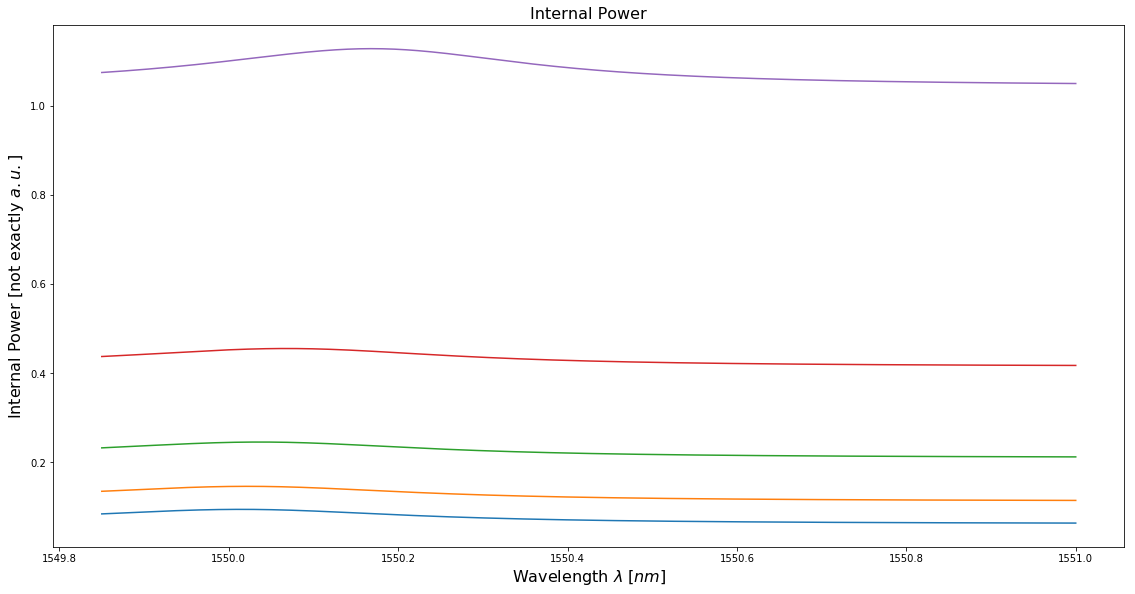

In [15]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])

for E_idx in range(E_size):
    #if E_idx <4:
        #ax1.plot(1e9*f2w(ω_range*ω0,), d['xΔN'][:,E_idx,0], label='ΔN')
        ax1.plot(1e9*f2w(ω_range*ω0,), d['xΔT'][:,E_idx,0], label='ΔT')
        #ax1.plot(1e9*f2w(ω_range*ω0,), np.real(d['xΔω'][:,E_idx,0])/ω0, label='RE[Δω]')
        #ax1.plot(1e9*f2w(ω_range*ω0,), np.imag(d['xΔω'][:,E_idx,0])/ω0, label='IM[Δω]', ls='--')

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

#legend = ax1.legend(loc='upper right', fontsize=16)#, bbox_to_anchor=(1, 0.5))

plt.show()
plt.close()

In [7]:
vectω = []
vectP = []

for E_idx in range(E_size):
    indx = np.where( np.abs(d['xUs'][:,E_idx,0])**2==max(np.abs(d['xUs'][:,E_idx,0])**2) )
    tmp = f2w(ω_range[indx]*ω0)
    vectω.append(tmp[0])
    tmp = np.abs(d['xUs'][indx,E_idx,0])**2
    vectP.append(tmp[0][0])
del indx, tmp
vectω = np.array(vectω)
vectP = np.array(vectP)
#print(vectω)
#print(vectP)

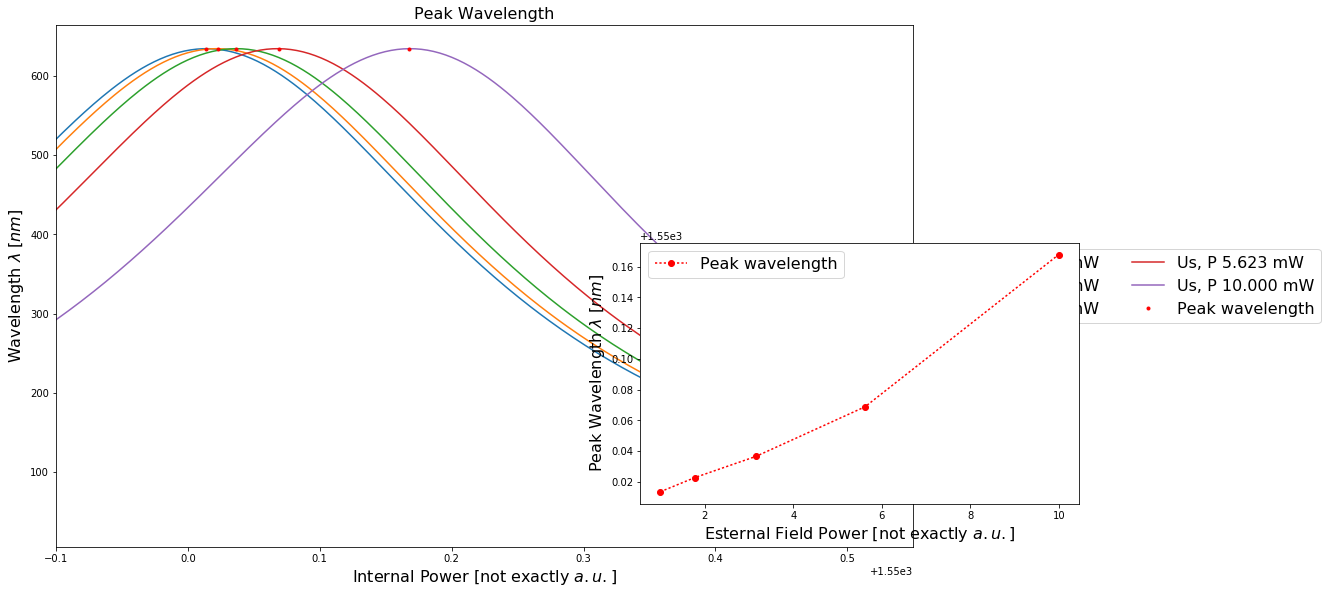

In [8]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

for E_idx in range(E_size):
    ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['xUs'][:,E_idx,0])**2, label='Us, P %.3f mW'%E_range[E_idx]**2)

ax1.set_xlim([1549.9, 1550.55])

ax1.plot(np.array(vectω)*1.0e9, vectP, '.', label='Peak wavelength', color='red')

ax1.set_title( r'Peak Wavelength', fontsize=16)
ax1.set_xlabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

if E_size <20:
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    legend = ax1.legend(loc='center left', fontsize=16, bbox_to_anchor=(1, 0.5), ncol=2)
else:
    legend = ax1.legend(bbox_to_anchor=(0., -.3, 1., .1), loc=3, ncol=8, mode="expand", borderaxespad=0.)
    
ax2 = fig.add_subplot(122)

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength', color='red')

ax2.set_ylabel(r'Peak Wavelength $\lambda$ $[nm]$', fontsize=16)
ax2.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 *1.5, box.width * 0.9, box.height * 0.5])

legend = ax2.legend(loc='upper left', fontsize=16)#, bbox_to_anchor=(1, 0.5))

plt.show()
plt.close()

In [9]:
p2 = np.poly1d(np.polyfit(E_range**2, vectω, 2))
p3 = np.poly1d(np.polyfit(E_range**2, vectω, 3))
p4 = np.poly1d(np.polyfit(E_range**2, vectω, 4))

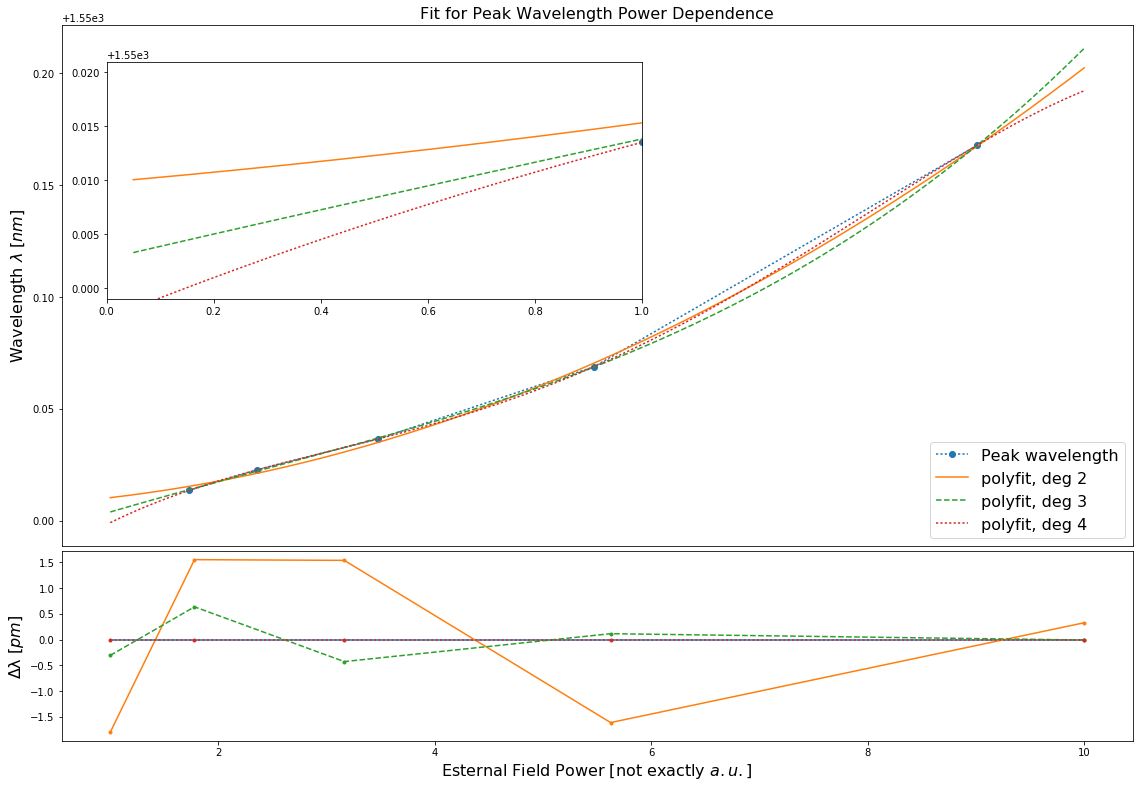

In [10]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

ax1.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.1, 10**(1.05), 200)
ax1.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax1.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax1.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

ax1.set_title( r'Fit for Peak Wavelength Power Dependence', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
#ax1.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.xticks([])

legend = ax1.legend(loc='lower right', fontsize=16)#, bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(211)

ax2.set_xlim([0, 1])
ax2.set_ylim([1549.999, 1550.021])
plt.yticks(np.linspace(1550,1550.02,5))

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.05, 1, 200)
ax2.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax2.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax2.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

box = ax2.get_position()
ax2.set_position([box.x0*1.26, box.y0 *0.9, box.width * 0.5, box.height])

ax3 = fig.add_subplot(212)

box = ax3.get_position()
ax3.set_position([box.x0, -1.25 * box.y0, box.width, box.height*0.8])

ax3.plot(E_range**2, E_range*0, '-')
ax3.plot(E_range**2, (np.array(vectω)-p2(E_range**2)) * 1e12, '.-', label='Δλ polyfit, deg 2')
ax3.plot(E_range**2, (np.array(vectω)-p3(E_range**2)) * 1e12, '.--', label='Δλ polyfit, deg 3')
ax3.plot(E_range**2, (np.array(vectω)-p4(E_range**2)) * 1e12, '.:', label='Δλ polyfit, deg 4')

#ax1.set_title( r'Residuals', fontsize=16)
ax3.set_ylabel(r'Δλ $[pm]$', fontsize=16)
ax3.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.show()
plt.close()

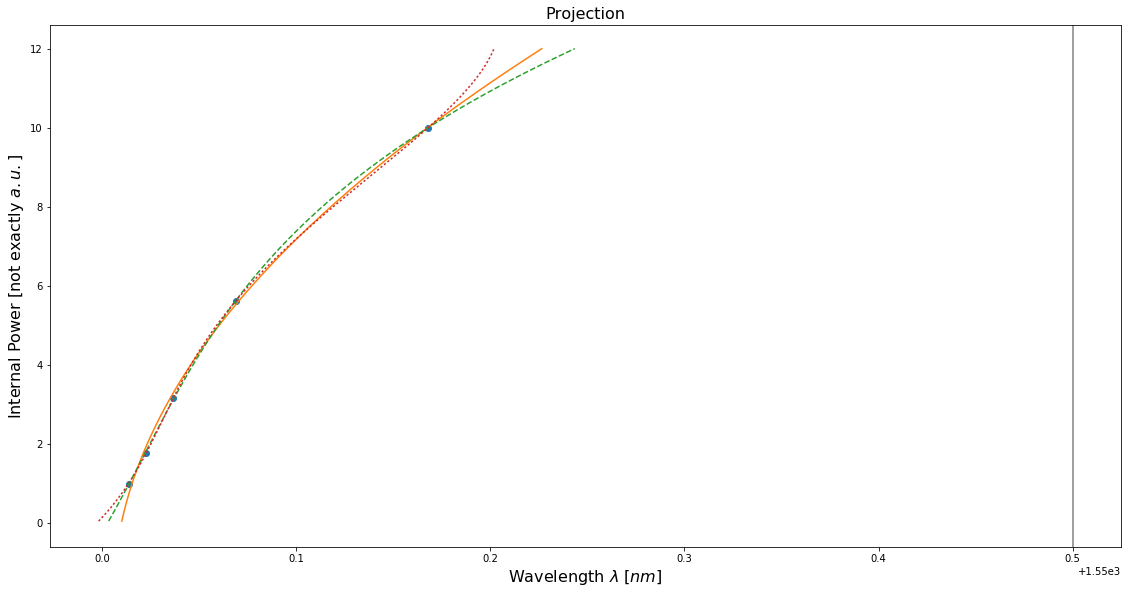

In [11]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

xp = np.linspace(.05, 12, 200)
ax1.plot
ax1.plot(1e9*vectω, E_range**2, 'o')
ax1.plot(p2(xp)*1e9, xp, '-')
ax1.plot(p3(xp)*1e9, xp, '--')
ax1.plot(p4(xp)*1e9, xp, ':')

ax1.vlines([1550.5], 0, 1, transform=ax1.get_xaxis_transform(), color='grey')

ax1.set_title( r'Projection', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

#legend = ax1.legend(loc='upper right', fontsize=16)#, bbox_to_anchor=(1, 0.5))

plt.show()
plt.close()

In [12]:
bistabilityω = []
bistabilityP = []

for E_idx in range(E_size):
    indx = np.where( np.diff(np.abs(d['xUs'][:,E_idx,0])**2)==min(np.diff(np.abs(d['xUs'][:,E_idx,0])**2)) )
    tmp = f2w(ω_range[indx]*ω0)
    bistabilityω.append(tmp[0])
    tmp = np.abs(d['xUs'][indx,E_idx,0])**2
    bistabilityP.append(tmp[0][0])
del indx, tmp
bistabilityω = np.array(bistabilityω)
bistabilityP = np.array(bistabilityP)
print(bistabilityω)
print(bistabilityP)

[  1.55015174e-06   1.55015865e-06   1.55017478e-06   1.55020473e-06
   1.55030380e-06]
[ 476.86395557  478.19099782  475.83874886  477.88727442  477.23736129]


In [13]:
start = 34
stop = 38

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

for E_idx in range(E_size):
    ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['xUs'][:,E_idx,0])**2, label='Us, P %.3f mW'%E_range[E_idx]**2)

ax1.set_xlim([1549.9, 1550.55])

ax1.plot(np.array(bistabilityω[start:stop])*1.0e9, bistabilityP[start:stop], '.', label='Peak wavelength', color='red')

ax1.set_title( r'Peak Wavelength', fontsize=16)
ax1.set_xlabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

if E_size <20:
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    legend = ax1.legend(loc='center left', fontsize=16, bbox_to_anchor=(1, 0.5), ncol=2)
else:
    legend = ax1.legend(bbox_to_anchor=(0., -.3, 1., 0.), loc=3, ncol=8, mode="expand", borderaxespad=0.)
    
ax2 = fig.add_subplot(122)

ax2.plot(E_range[start:stop]**2, np.abs(d['xUtot'][np.array(bistabilityω[start:stop]),start:stop,0])**2,
         #np.array(bistabilityω[start:stop])*1.0e9,
         marker='o', ls=':', label='Peak wavelength', color='red')

ax2.set_ylabel(r'Peak Wavelength $\lambda$ $[nm]$', fontsize=16)
ax2.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 *1.5, box.width * 0.9, box.height * 0.5])

legend = ax2.legend(loc='lower left', fontsize=16)#, bbox_to_anchor=(1, 0.5))

plt.show()
plt.close()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
print(np.linspace(start,stop+1,2+stop-start))